# Quickstart


`AutoEmulate`'s goal is to make it easy to create an emulator for your simulation. Here's the basic workflow:

In [2]:
import numpy as np
import random
import torch
from autoemulate.compare import AutoEmulate
from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.projectile import simulate_projectile

In [5]:
seed = 43 
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## Design of Experiments

Before we build an emulator or surrogate model, we need to get a set of input/output pairs from the simulation. This is called the **Design of Experiments (DoE)** and is currently not a key part of `AutoEmulate`, as this step is tricky to automate and will run on more complex compute infrastructure for expensive simulations. There are lots of sampling techniques, but here we are using Latin Hypercube Sampling.   

Below, `simulate_projectile` is a simulation for a projectil motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). It takes two inputs, the drag coefficient (on a log scale) and the velocity and outputs the distance the projectile travelled. We sample 100 sets of inputs `X` using a Latin Hypercube Sampler and run the simulator for those inputs to get the outputs `y`.

In [6]:
# sample from a simulation
lhd = LatinHypercube([(-5., 1.), (0., 1000.)]) # (upper, lower) bounds for each parameter
X = lhd.sample(100)
y = np.array([simulate_projectile(x) for x in X])
X.shape, y.shape

((100, 2), (100,))

## Comparing emulators

This is the core of `AutoEmulate`. With a set of inputs / outputs, we can run a full machine learning pipeline, including data processing, model fitting, model selection and potentially hyperparameter optimisation in just a few lines of code. First, we initialise an `AutoEmulate` object. Then, we run `setup(X, y)`, providing the simulation inputs and outputs. Lastly, `compare()` will fit a range of different models to the data and evaluate them using cross-validation, returning the best emulator.

In [7]:
# compare emulator models
ae = AutoEmulate()
ae.setup(X, y)
ae.compare()

,Values
Simulation input shape (X),"(100, 2)"
Simulation output shape (y),"(100,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


Initializing:   0%|          | 0/8 [00:00<?, ?it/s]

Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianProcess())])

We can have a look at the average cross-validation results for each model:

In [8]:
ae.summarise_cv()

,model,short,rmse,r2
0,GaussianProcess,gp,546.703381,0.993752
1,RadialBasisFunctions,rbf,1037.254646,0.978469
2,ConditionalNeuralProcess,cnp,2196.036382,0.908314
3,SupportVectorMachines,svm,3299.432460,0.812614
4,RandomForest,rf,3855.153473,0.692546
5,GradientBoosting,gb,3633.381679,0.686120
6,SecondOrderPolynomial,sop,3974.504619,0.577358
7,LightGBM,lgbm,5213.820303,0.325861


And create plots comparing the models:

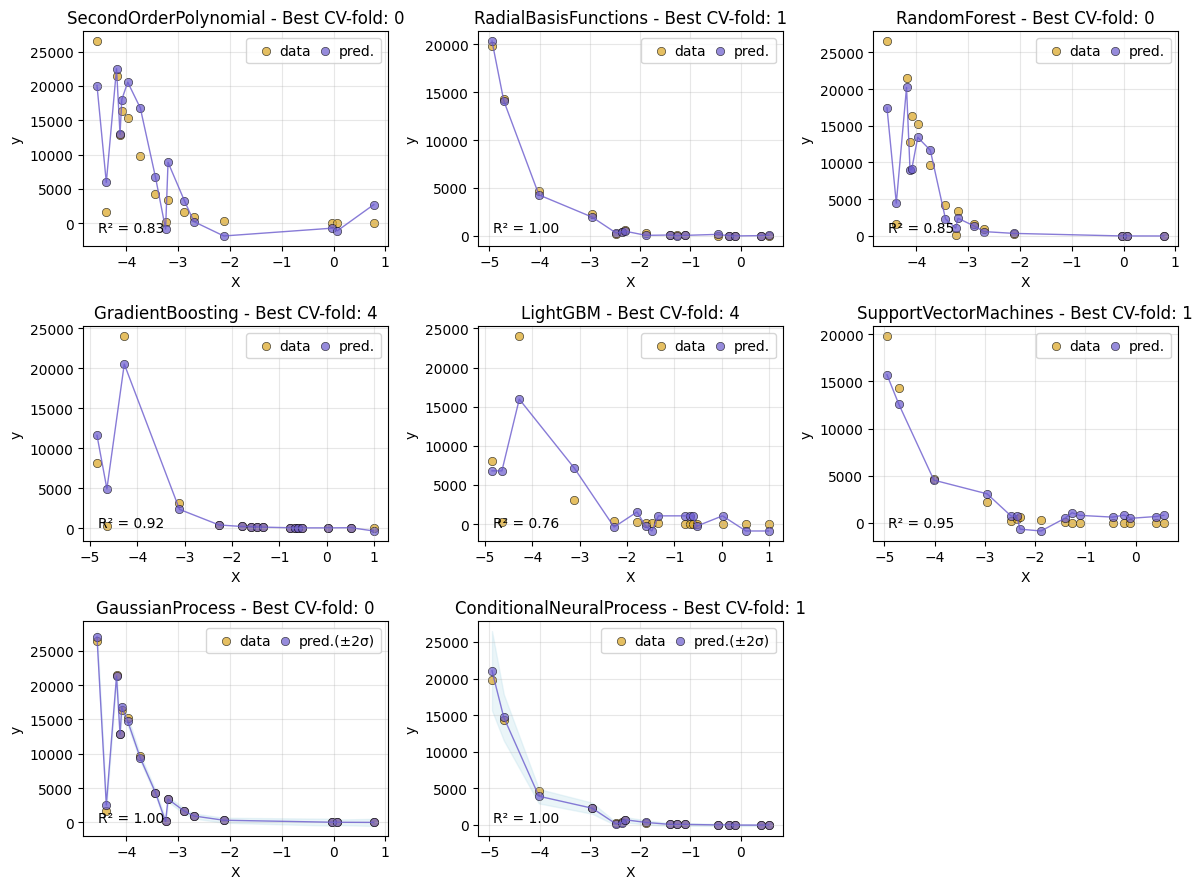

In [9]:
ae.plot_cv()

## Evaluating on the test set

`AutoEmulate` has already split the data into a training set and a test set. After looking at the cross-validation results, we can retrieve a fitted emulator and evaluate it on the test set. The GP predicts well on unseen data.

In [24]:
gp = ae.get_model("GaussianProcess")
ae.evaluate(gp)

,model,short,rmse,r2
0,GaussianProcess,gp,42.9048,0.9999


But it's always useful to plot the predictions too.

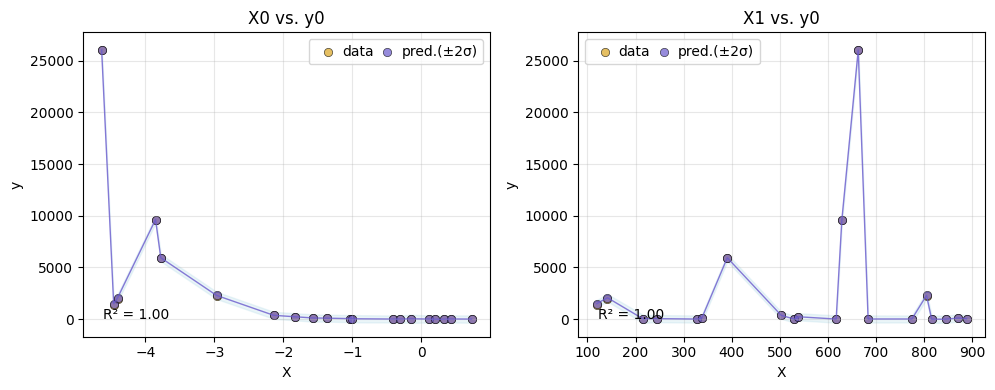

In [25]:
ae.plot_eval(gp, input_index=[0, 1])

## Refitting the emulator

Before applying the emulator, we refit it on the entire dataset, including training and test set. This is done with the `refit()` method.


In [14]:
gp_final = ae.refit(gp)

## Predictions

We can use the best model to make predictions for new inputs. Emulators in `AutoEmulate` are `scikit-learn` estimators, so we can use the `predict` method to make predictions. 

In [26]:
gp_final.predict(X[:10])

array([ 5.92939290e+03,  8.09046507e+03,  1.64320911e+04,  8.03490268e+03,
        1.02448510e+02, -4.17794195e+00,  5.90299787e+00,  5.88865420e+01,
        1.08363490e+04,  6.84075971e+00])

## Sensitivity analysis

A common task for emulators is Global Sensitivity Analysis. We can perform this with the `sensitivity_analysis` method. 

In [27]:
si = ae.sensitivity_analysis(gp_final)
si

,output,parameter,index,value,confidence
0,y1,X1,S1,0.612608,0.127283
1,y1,X2,S1,0.080126,0.060803
2,y1,X1,ST,0.919932,0.144268
3,y1,X2,ST,0.385957,0.105767
4,y1,X1-X2,S2,0.322638,0.274036


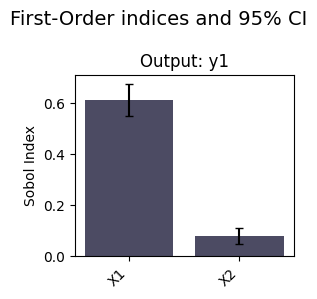

In [28]:
ae.plot_sensitivity_analysis(si, index="S1", figsize=(3, 3))

## Saving / loading models

Lastly, we can save and load an emulator. To load, we need an initialised `AutoEmulate` object. This will ensure that the environment in which the model was saved is similar to the environment in which it is loaded.

In [ ]:
# save & load best emulator
# ae.save(gp_final, "gp_final")
# emulator = ae.load("gp_final")